### Машинное обучение
## Домашнее задание №3 - Градиентный бустинг

**Общая информация**

**Срок сдачи:** 5 декабря 2023, 23:59   
**Штраф за опоздание:** -2 балла за каждые сутки

Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Считаем производные для функций потерь (1 балл)

Мы будем реализовать градиентный бустинг для 3 функций потерь:

1) MSE  $L(a(x_i), y_i) = (y_i - a(x_i)) ^ 2$

2) Экспоненциальная  $L(a(x_i), y_i) = exp( -a(x_i) y_i), y_i \in \{-1, 1\}$

3) Логистическая  $L(a(x_i), y_i) = \log (1 + exp( -a(x_i) y_i)), y_i \in \{-1, 1\}$

где $a(x_i)$ предсказание бустинга на итом объекте. 

Для каждой функции потерь напишите таргет, на который будет настраиваться каждое дерево в бустинге. 

1. MSE  
$L = (y_i - a_i) ^ 2$  
$\frac{dL}{da_i} = -2 * a_i * (y_i - a_i)$


2. Exponential  
$L = e^{-a_i * y_i}$  
$\frac{dL}{da_i} = -y_i * e^{-a_i * y_i} = - \frac{y_i}{e^{a_i * y_i}}$


3. Logistic  
$L = log(1 + e^{-a_i * y_i})$  
$\frac{dL}{da_i} = \frac{-y_i * e^{-a_i * y_i}}{1 + e^{-a_i * y_i}} = - \frac{y_i}{1 + e^{a_i * y_i}}$  

##  Реализуем градиентный бустинг (3 балла)

Реализуйте класс градиентного бустинга для классификации. Ваша реализация бустинга должна работать по точности не более чем на 5 процентов хуже чем GradientBoostingClassifier из sklearn. 


Детали реализации:

-- должно поддерживаться 3 функции потерь

-- сами базовые алгоритмы(деревья, линейные модели и тп) реализовать не надо, просто возьмите готовые из sklearn

-- в качестве функции потерь для построения одного дерева используйте MSE

-- шаг в бустинге можно не подбирать, можно брать константный

-- можно брать разные модели в качестве инициализации бустинга

-- должны поддерживаться следующие параметры:

а) число итераций
б) размер шага
в) процент случайных фичей при построении одного дерева
д) процент случайных объектов при построении одного дерева
е) параметры базового алгоритма (передавайте через **kwargs)

In [1]:
import numpy as np

from sklearn.datasets import load_wine
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

In [2]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)

In [12]:
class Ansemble:
    
    def __init__(self):
        self.models = []
        
    def add_model(self, model, weight):
        self.models.append((weight, model))
    
    def predict(self, X):
        result = 0
        for weight, model in self.models:
            predict = model.predict(X)
            if len(predict.shape) == 1:
                predict = np.array([1 - predict, predict]).T
            result += weight * predict
        return result
    
    def __call__(self, X):
        return self.predict(X)

class ConstantModel:
    
    def __init__(self, c):
        self.c = c
    def predict(self, X):
        return np.full((X.shape[0]), self.c)
    
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=1, keepdims=True)


class FewClassesTree:
    
    def __init__(self, trees, features=None):
        self.trees = trees
        self.features = features
        
    def predict(self, X):
        X_sampled = X
        if self.features is not None:
            X_sampled = X[:, self.features]
        predicts = []
        for tree in self.trees:
            predicts.append(tree.predict(X_sampled))
        return np.array(predicts).T
    

class MyGradientBoostingClassifier:

    def __init__(self, loss='mse', learning_rate=0.1, n_estimators=100, subsample=None, colsample=1.0, *args, **kwargs):
        """
        loss -- один из 3 лоссов:
        learning_rate -- шаг бустинга
        n_estimators -- число итераций
        colsample -- процент рандомных признаков при обучнеии одного алгоритма
        colsample -- процент рандомных объектов при обучнеии одного алгоритма
        args, kwargs -- параметры  базовых моделей
        """
        
        assert loss in ['mse', 'exponential', 'log_loss']
        self.loss = loss
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.colsample = colsample
        self.subsample = subsample
        self.args = args
        self.kwargs = kwargs
        
        self.final_model = None
        self.classes = None
        
    def _grad(self, y_true, y_pred):
        
        if self.loss == 'mse':
            return -2 * y_pred * (y_true - y_pred)
        
        if self.loss == 'exponential':
            return -y_true / np.exp(y_true * y_pred)
            
        if self.loss == 'log_loss':
            return -y_true / np.exp(1 + y_true * y_pred)
    
    def fit(self, X, y, base_model=DecisionTreeRegressor, init_model=None):
        """
        X -- объекты для обучения:
        y -- таргеты для обучения
        base_model -- класс базовых моделей, например sklearn.tree.DecisionTreeRegressor
        init_model -- класс для первой модели, если None то берем константу (только для посл задания)
        """
            
        self.classes, counts = np.unique(y, return_counts=True)
        probas = counts / np.sum(counts)
        
        y_ohe = np.eye(len(self.classes))[y]
        
        self.final_model = Ansemble()
        
        if init_model is not None:
            init_model.fit(X, y)
            self.final_model.add_model(init_model, 1.0)
            
        else:
            trees = []
            for k in self.classes:
                trees.append(ConstantModel(probas[k]))

            self.final_model.add_model(FewClassesTree(trees), 1.0)
        
        if self.subsample:
            n_subsamples = int(self.subsample * X.shape[0])        
        n_colsamples = int(self.colsample * X.shape[1])
        
        last_outputs = self.final_model(X)
        for n_iter in range(self.n_estimators):
            antigrad = -self._grad(y_ohe, last_outputs)
            
            current_model = None
            trees = []
            
            if self.subsample:
                subsamples = np.random.choice(np.arange(X.shape[0]), size=n_subsamples, replace=True)
            else:
                subsamples = np.arange(X.shape[0])
                
            colsamples = np.random.choice(np.arange(X.shape[1]), size=n_colsamples, replace=False)
            val, cnts = np.unique(subsamples, return_counts=True)
            X_sampled = X[subsamples, :][:, colsamples]
            y_sampled = antigrad[subsamples, :]
            for k in self.classes:
                
                new_estimator = base_model(*self.args, **self.kwargs)
                new_estimator.fit(X_sampled, y_sampled[:, k])
                trees.append(new_estimator)
            
            current_model = FewClassesTree(trees, colsamples)
            
            weight = self.learning_rate
            self.final_model.add_model(current_model, weight)
            
            last_outputs += weight * current_model.predict(X)
        
    def predict_proba(self, X):
        assert self.final_model, "MyGradientBoostingClassifier wasn't fitted"
        return softmax(self.final_model(X))
    
    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

In [13]:
my_clf = MyGradientBoostingClassifier()
clf = GradientBoostingClassifier()

In [14]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)

In [15]:
my_clf.fit(X_train, y_train)
clf.fit(X_train, y_train)
print(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

0.9444444444444444
0.9444444444444444


## Подбираем параметры (2 балла)

Давайте попробуем применить Ваш бустинг для предсказаний цены домов в Калифорнии. Чтобы можно было попробовтаь разные функции потерь, переведем по порогу таргет в 2 класса: дорогие и дешевые дома.

В задании нужно

1) Построить график точности в зависимости от числа итераций на валидации.

2) Подобрать оптимальные параметры Вашего бустинга на валидации. 


In [16]:
from sklearn.datasets import fetch_california_housing
X, y = fetch_california_housing(return_X_y=True)

In [17]:
# Превращаем регрессию в классификацию
y = (y > 2.0).astype(int)
print(X.shape, y.shape)

(20640, 8) (20640,)


In [18]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y)

In [19]:
from sklearn.metrics import accuracy_score
from tqdm import tqdm

In [12]:
metrics = {'train': [], 'val': [], 'n_estim': []}

for n_estim in tqdm([1, 10, 50, 100, 250]):
    my_clf = MyGradientBoostingClassifier(n_estimators=n_estim)
    my_clf.fit(X_train, y_train)
    
    metrics['n_estim'].append(n_estim)
    metrics['train'].append(accuracy_score(y_true=y_train, y_pred=my_clf.predict(X_train)))
    metrics['val'].append(accuracy_score(y_true=y_val, y_pred=my_clf.predict(X_val)))

100%|█████████████████████████████████████████████| 5/5 [01:52<00:00, 22.60s/it]


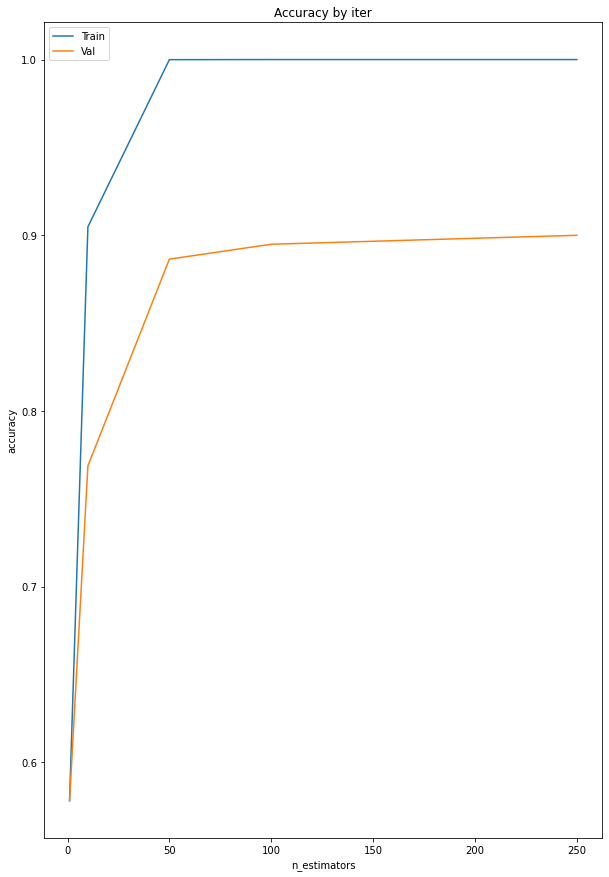

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 15))
plt.title("Accuracy by iter")
plt.xlabel("n_estimators")
plt.ylabel("accuracy")
plt.plot(metrics['n_estim'], metrics['train'], label='Train')
plt.plot(metrics['n_estim'], metrics['val'], label='Val')
plt.legend()
plt.show()

In [44]:
## Не наследуемся от склерновского класса, поэтому GridSearch не заходит

for loss in ['mse', 'log_loss', 'exponential']:
    for lr in [1, 0.1, 0.01]:
        for max_depth in [3, 6, 10]:
            print(f"Params: loss = {loss}, lr = {lr}, max_depth = {max_depth}")  
            try:
                model = MyGradientBoostingClassifier(loss, lr, max_depth=max_depth)
                model.fit(X_train, y_train)
                print(f"Train acc: {accuracy_score(y_true=y_train, y_pred=model.predict(X_train))}")
                print(f"Val acc: {accuracy_score(y_true=y_val, y_pred=model.predict(X_val))}")                            
            except Exception as e:
                print(f"skip: {e}")
#             model = GradientBoostingClassifier(loss=loss, learning_rate=lr)

Params: loss = mse, lr = 1, max_depth = 3


/tmp/ipykernel_298856/2947093488.py:74: RuntimeWarning: overflow encountered in multiply
  return -2 * y_pred * (y_true - y_pred)


skip: Input y contains infinity or a value too large for dtype('float64').
Params: loss = mse, lr = 1, max_depth = 6


/tmp/ipykernel_298856/2947093488.py:74: RuntimeWarning: overflow encountered in multiply
  return -2 * y_pred * (y_true - y_pred)


skip: Input y contains infinity or a value too large for dtype('float64').
Params: loss = mse, lr = 1, max_depth = 10


/tmp/ipykernel_298856/2947093488.py:74: RuntimeWarning: overflow encountered in multiply
  return -2 * y_pred * (y_true - y_pred)


skip: Input y contains infinity or a value too large for dtype('float64').
Params: loss = mse, lr = 0.1, max_depth = 3
Train acc: 0.8863250968992248
Val acc: 0.8844476744186046
Params: loss = mse, lr = 0.1, max_depth = 6
Train acc: 0.9385901162790697
Val acc: 0.8989825581395349
Params: loss = mse, lr = 0.1, max_depth = 10
Train acc: 0.9983648255813954
Val acc: 0.9026162790697675
Params: loss = mse, lr = 0.01, max_depth = 3
Train acc: 0.8231589147286822
Val acc: 0.8304263565891473
Params: loss = mse, lr = 0.01, max_depth = 6
Train acc: 0.8815406976744186
Val acc: 0.8757267441860465
Params: loss = mse, lr = 0.01, max_depth = 10
Train acc: 0.9522165697674418
Val acc: 0.8900193798449613
Params: loss = log_loss, lr = 1, max_depth = 3
Train acc: 0.8462330426356589
Val acc: 0.8524709302325582
Params: loss = log_loss, lr = 1, max_depth = 6
Train acc: 0.8886264534883721
Val acc: 0.8810562015503876
Params: loss = log_loss, lr = 1, max_depth = 10
Train acc: 0.9609375
Val acc: 0.8968023255813954
P

Лучше параметры - loss = mse, lr = 0.1, max_depth = 10

Лучший скор = 0.9026162790697675

## BooBag BagBoo (1 балл)



Попробуем объединить бустинг и бэгинг. Давайте

1) в качестве базовой модели брать не дерево решений, а случайный лес (из sklearn)

2) обучать N бустингов на бустрапированной выборке, а затем предикт усреднять

Попробуйте обе этих стратегии на данных из прошлого задания. Получилось ли улучшить качество? Почему?

### 1

In [21]:
from sklearn.ensemble import RandomForestRegressor

In [22]:

model = MyGradientBoostingClassifier('mse', 0.001, 10)
model.fit(X_train, y_train, RandomForestRegressor)

print(f"Train acc: {accuracy_score(y_true=y_train, y_pred=model.predict(X_train))}")
print(f"Val acc: {accuracy_score(y_true=y_val, y_pred=model.predict(X_val))}")               

Train acc: 0.5780644379844961
Val acc: 0.5780038759689923


Итоговые метрики c MSE не улучшаются, при этом антиградиент изначально маленький и растёт, даже с маленьким lr - значит мы ухудшаем предсказания новыми моделями, потому что базовая модель итак очень хорошая.

In [54]:

model = MyGradientBoostingClassifier('log_loss', 1, 20)
model.fit(X_train, y_train, RandomForestRegressor)

print(f"Train acc: {accuracy_score(y_true=y_train, y_pred=model.predict(X_train))}")
print(f"Val acc: {accuracy_score(y_true=y_val, y_pred=model.predict(X_val))}")               

[0.11929756 0.10179053]
[0.09866147 0.08212182]
[0.08442708 0.06914598]
[0.07455437 0.0605479 ]
[0.0666824  0.05378499]
[0.06007948 0.04812594]
[0.05481836 0.04372027]
[0.05026897 0.03994025]
[0.04666131 0.03695833]
[0.04349653 0.03438683]
[0.04072631 0.03215391]
[0.0382805  0.03016895]
[0.03610332 0.02840562]
[0.03411075 0.02678446]
[0.03239784 0.02543004]
[0.03083575 0.02418604]
[0.02938004 0.02302049]
[0.02812169 0.02203289]
[0.02694169 0.02110211]
[0.02585592 0.02025136]
Train acc: 0.9986676356589147
Val acc: 0.8982558139534884


Для log_loss антиградиент падает, но при этом итоговые метрики улучшаются совсем немного

### 2

In [29]:
ansemble = Ansemble()

nmodels = 5
for _ in range(nmodels):
    model = MyGradientBoostingClassifier('mse', 0.1, subsample=1.0, max_depth = 10)
    model.fit(X_train, y_train)

    print(f"Train acc: {accuracy_score(y_true=y_train, y_pred=model.predict(X_train))}")
    print(f"Val acc: {accuracy_score(y_true=y_val, y_pred=model.predict(X_val))}")               
    
    ansemble.add_model(model, 1.0 / nmodels)   
    
print("Ansemble metrics:")
print(f"Train acc: {accuracy_score(y_true=y_train, y_pred=(ansemble.predict(X_train)[:, 1] > 0.5).astype(int))}")
print(f"Val acc: {accuracy_score(y_true=y_val, y_pred=(ansemble.predict(X_val)[:, 1] > 0.5).astype(int))}")     

Train acc: 0.998062015503876
Val acc: 0.8929263565891473
Train acc: 0.9976986434108527
Val acc: 0.8951065891472868
Train acc: 0.9977592054263565
Val acc: 0.8934108527131783
Train acc: 0.9980014534883721
Val acc: 0.8914728682170543
Train acc: 0.9976986434108527
Val acc: 0.8902616279069767
Ansemble metrics:
Train acc: 0.9986070736434108
Val acc: 0.8943798449612403


Для MSE метрики не улучшаются

In [33]:
ansemble = Ansemble()

nmodels = 5
for _ in range(nmodels):
    model = MyGradientBoostingClassifier('log_loss', 1, 100, subsample=1.0, max_depth = 10)
    model.fit(X_train, y_train)

    print(f"Train acc: {accuracy_score(y_true=y_train, y_pred=model.predict(X_train))}")
    print(f"Val acc: {accuracy_score(y_true=y_val, y_pred=model.predict(X_val))}")               
    
    ansemble.add_model(model, 1.0 / nmodels)   
    
print("Ansemble metrics:")
print(f"Train acc: {accuracy_score(y_true=y_train, y_pred=(ansemble.predict(X_train)[:, 1] > 0.5).astype(int))}")
print(f"Val acc: {accuracy_score(y_true=y_val, y_pred=(ansemble.predict(X_val)[:, 1] > 0.5).astype(int))}")     

Train acc: 0.9543968023255814
Val acc: 0.8844476744186046
Train acc: 0.9538517441860465
Val acc: 0.8793604651162791
Train acc: 0.9547601744186046
Val acc: 0.8808139534883721
Train acc: 0.9530038759689923
Val acc: 0.8781492248062015
Train acc: 0.9524588178294574
Val acc: 0.8822674418604651
Ansemble metrics:
Train acc: 0.9544573643410853
Val acc: 0.8798449612403101


Для log_loss метрики также не улучшаются

## Умная инициализация (1 балл)

Попробуйте брать в качестве инициализации бустинга не константу, а какой-то алгоритм и уже от его предикта стартовать итерации бустинга. Попробуйте разные модели из sklearn: линейные модели, рандом форест, svm..

Получилось ли улучшить качество? Почему?



In [81]:
from sklearn.linear_model import LogisticRegression

In [104]:
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVR, SVC

In [112]:
for init_model in [LinearRegression, RandomForestRegressor, SVR]:
    print(f"Init model: {init_model}")
    try:
        model = MyGradientBoostingClassifier('mse', 0.01, max_depth = 10)
        model.fit(X_train, y_train, init_model=init_model())

        print(f"Train acc: {accuracy_score(y_true=y_train, y_pred=model.predict(X_train))}")
        print(f"Val acc: {accuracy_score(y_true=y_val, y_pred=model.predict(X_val))}")               
    except Exception as e:
        print(f"exception: {e}")

Init model: <class 'sklearn.linear_model._base.LinearRegression'>


/tmp/ipykernel_298856/3755535427.py:77: RuntimeWarning: overflow encountered in multiply
  return -2 * y_pred * (y_true - y_pred)


exception: Input y contains infinity or a value too large for dtype('float64').
Init model: <class 'sklearn.ensemble._forest.RandomForestRegressor'>
Train acc: 1.0
Val acc: 0.8909883720930233
Init model: <class 'sklearn.svm._classes.SVR'>
Train acc: 0.8634932170542635
Val acc: 0.8197674418604651


Почему-то не получается улучшить качество. Может быть, требуется более качественная настройка каждого из базовых алгоритмов

## Фидбек (бесценно)

* Какие аспекты обучения  ансамблей Вам показались непонятными? Какое место стоит дополнительно объяснить?

На лекции ничего не разбиралось про многоклассовую классификацию в бустинге, вообще ни слова - пришлось читать sklearn и разбираться самому. Прикольно, решение логичное, но можно было хотя бы вкратце описать алгоритм, чтобы было не так непонятно в начале